# Stock category prediction using XGBoost

In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read PCA parameters

In [2]:
D=pickle.load(open('data/PCA.pickle','rb'))
col=D['columns']
eigvec=D['eigvec']
eigval=D['eigval']

### Sanity check
The following scatterplot should be very similar to the scatter plot you produced in notebook 3 for eigvec 1, eigvec 2 (indexing starts with 1)

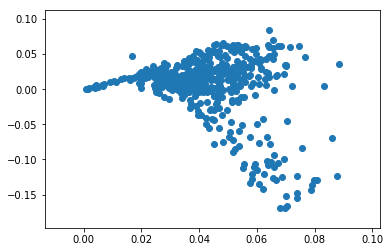

In [3]:
scatter(eigvec[:,0],eigvec[:,1])

## compute features

In [4]:
#Taking the top 20 features(Eigen vectors)
features=eigvec[:,:20]
features.shape

(481, 20)

##  Compute labels (sectors)

In [5]:
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


## Creating necessary dictionaries

The Sectors dictionary below has the Sector name mapped to the sector ID. Using the Sectors dictionary below, create a dictionary mapping of the sector ID to indices incrementally as follows:

```
{
    'CD': 0,
    'CS': 1,
    'EN': 2,
    'FIN': 3,
    'HC': 4,
    'INDS': 5,
    'IT': 6,
    'MAT': 7,
    'RE': 8,
    'TS': 9,
    'UTIL': 10
}
```

In addition to this, you will need to create one more dictionary mapping index number to the sector name:
```
{
    0: 'Consumer Discretionary',
    1: 'Consumer Staples',
    2: 'Energy',
    3: 'Financials',
    4: 'Health Care',
    5: 'Industrials',
    6: 'Information Technology',
    7: 'Materials',
    8: 'Real Estate',
    9: 'Telecommunication Services',
    10: 'Utilities'
}
 ```
 
**<font color="magenta" size=2>Input</font>**
<br>
A dictionary **Sectors** as given in the following cell.

**<font color="blue" size=2>Output</font>**
<br>
Return two dictionaries **sector2number** and **number2sectorName** as mentioned in the description.

In [6]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}


In [7]:
def get_sector_dicts(Sectors):
    sector2number = {}
    number2sectorName = {}
    
    for i, (k, v) in enumerate(sorted(Sectors.items())):
        sector2number[v] = i
        number2sectorName[i] = k
        
    return sector2number, number2sectorName

In [8]:
sector2number, number2sectorName = get_sector_dicts(Sectors)

In [9]:
# Hidden Tests here

In [10]:
labels=[]
feature_vectors=[]
feature_vectors_test=[]
test_nos = []
for i in range(len(col)):
    c=col[i]
    if 'train' in c:
        ticker=c[6:-2]
        answer=list(TickerInfo[TickerInfo.Ticker==ticker]['SECTOR_ID'])
        if len(answer)==1:
            sector_no=sector2number[answer[0]]
            labels.append(sector_no)
            feature_vectors.append(features[i,:])
        else:
            print('error: could not find sector for ticker:',ticker)
    if 'test' in c:
        test_nos.append(c[5:-2])
        feature_vectors_test.append(features[i,:])

In [11]:
len(labels),len(feature_vectors), len(test_nos),len(feature_vectors_test)

(392, 392, 89, 89)

## XGBoost Setup

In [12]:
X=np.array(feature_vectors)
y=np.array(labels)
X_test = np.array(feature_vectors_test)
y_test = np.array(test_nos)
X.shape, y.shape, X_test.shape, y_test.shape

((392, 20), (392,), (89, 20), (89,))

In [13]:
#Splitting between train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=6)
X_train.shape, X_valid.shape

((274, 20), (118, 20))

In [14]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=11

num_round = 100

## Generating scores using XGBoost

The function <font color="blue">get_margin_scores</font> is used to predict the sector for each of the given samples.

**<font color="magenta" size=2>Input</font>**
<br>
1. **Training set** (X_train)
2. **Validation set** (X_valid)
3. **Training labels** (y_train)
4. **XGBoost Parameter List** (param)


**<font color="blue" size=2>Output</font>**
<br>
Return the following:
1. **y_pred_valid**: The raw output scores for the validation set


**Note**:
1. Round all raw scores to **three** decimal places
2. Remember to use **verbose_eval = False** while training and **ntree_limit=bst.best_ntree_limit** and **output_margin=True** while predicting

In [15]:
def get_margin_scores(X_train, X_valid, y_train, param):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)

    bst = xgb.train(param, dtrain, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [16]:
y_pred_valid = get_margin_scores(X_train, X_valid, y_train, param)

In [17]:
assert y_pred_valid.shape == (118, 11), "Incorrect shape"
assert type(y_pred_valid) == numpy.ndarray, "Incorrect type"

In [18]:
# Hidden Tests Here

## Computing Top1 and Top5 predictions

Using the margin scores generated, calculate top1 and top5 predictions for the given data:

**top1**: Find the most probable prediction for each example in the validation set

**top5**: Find the top 5 most probable predictions in descending order for each example in the validation set (most probable to fifth most probabale)

**<font color="magenta" size=2>Input</font>**
<br>
1. **Validation Output Scores** (y_pred_valid)

**<font color="blue" size=2>Output</font>**
<br>
1. **predictions_valid**: The most probable prediction for each example in the the validation set
2. **predictions_topn**: The top 5 predictions for each example in the validation set

**<font color="magenta" size=2>Sample input</font>**
1. **y_pred_valid**: [[-0.3, 1.2, 0.3, 0.5, -0.4, 0.0, 0.01, 1.0, -1.3, 0.2, -1.2], [0.4, -0.5, 1.3, -0.2, 0.6, -2.2, -0.8, 1.9, 0.9, -0.2, -1.7]]

**<font color="blue" size=2>Sample output</font>** 
1. **predictions_valid**: [1, 7]
2. **predictions_top5**: [[1,  7,  3,  2,  9], [ 7,  2,  8,  4,  0]]

In [19]:
def get_predictions(y_pred_valid):
    y_pred_sort = np.argsort(-y_pred_valid, axis=1)
    
    predictions_valid = y_pred_sort[:, 0].reshape(-1)
    predictions_top5 = y_pred_sort[:, :5]
    
    return predictions_valid, predictions_top5

In [20]:
predictions_valid, predictions_top5 = get_predictions(y_pred_valid)

In [21]:
assert predictions_valid.shape == (118,), "Incorrect shape"
assert predictions_top5.shape == (118, 5), "Incorrect shape"
assert type(predictions_valid) == numpy.ndarray, "Incorrect type"
assert type(predictions_top5) == numpy.ndarray, "Incorrect type"

In [22]:
# Hidden Tests Here

In [23]:
# Hidden Tests Here

In [24]:
acc = 0
for i in range(5):
    acc += sum(predictions_top5[:, i]==y_valid)
    print("Top ", i+1, ": \t", acc/len(y_valid))

Top  1 : 	 0.7033898305084746
Top  2 : 	 0.864406779661017
Top  3 : 	 0.923728813559322
Top  4 : 	 0.940677966101695
Top  5 : 	 0.9491525423728814


## Generating the confusion matrix

What is a confusion matrix?
This is a useful link that explains this: https://en.wikipedia.org/wiki/Confusion_matrix#Example

We will now be using the top 2 values of the **predictions_top5** matrix generated, to produce the confusion matrix. We will be creating a confusion matrix by comparing the most probable prediction against the second most probable prediction. We are doing this to analyse the scenarios where the second most probable prediction is in fact the correct prediction. So remember to take **only the top2** from the **predictions_top5** matrix. For generating this matrix we do not need more than that.

An example with 4 classes (0, 1, 2, 3):

If 2 is getting confused with 1, i.e., if 1 is the top prediction and 2 is the second-top prediction, then your confusion matrix should add 1 to the cell (1, 2).

Different example scenarios:

**Scenario 1**:

**<font color="magenta" size=2>Sample Input</font>**<br>
<br>
y_label = 3<br>
top2_predictions = [2, 3]

**<font color="blue" size=2>Output</font>**<br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 1]<br>
[0 0 0 0]<br>

**Scenario 2**:

**<font color="magenta" size=2>Sample Input</font>**<br>
<br>
Say we have 7 sample prediction values<br>
y_label = [3, 2, 3, 1, 0, 2, 2]<br>
top2_predictions = [[2, 3], [0, 3], [2, 3], [1, 2], [3, 0], [2, 0], [3, 2]]

**<font color="blue" size=2>Output</font>**<br><br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 2]<br>
[1 0 1 0]<br>

**Explanation**:

The first example has top two predictions: (2, 3) and the label 3. So we add 1 to the position (2,3).

The second example has 7 sample predictions: 
1. In two scenarios 2 is predicted in place of 3 and the cell (2,3) is incremented twice.
2. In two other scenarios we have a case where the second prediction is right. The corresponding cells {(3,0) and (3,2)} are incremented once each.
3. In two scenarios, the first element is the correct prediction. No cell is incremented then.
4. In one scenario, neither of the top 2 predictions is correct. No cell is incremented then.

**Note**: y_label is the same as y_valid here.

In [25]:
def get_confusion_matrix(predictions_top5, y_valid):
    top2 = predictions_top5[:,:2]
    n_classes = param['num_class']
    confusion_matrix = np.zeros((n_classes, n_classes), np.int)
    
    for i, x in enumerate(top2):
        if x[0] == y_valid[i]:
            continue
        elif x[1] == y_valid[i]:
            confusion_matrix[x[0], y_valid[i]] += 1
            
    return confusion_matrix

In [26]:
confusion_matrix = get_confusion_matrix(predictions_top5, y_valid)

In [27]:
assert confusion_matrix.shape == (11, 11), "Incorrect shape"
assert type(confusion_matrix) == numpy.ndarray, "Incorrect type"

In [28]:
# Hidden Tests Here

In [29]:
for i in range(confusion_matrix.shape[0]):
    print("%30s" % number2sectorName[i], "\t", confusion_matrix[i, :])

        Consumer Discretionary 	 [0 1 0 0 0 1 1 0 0 0 0]
              Consumer Staples 	 [1 0 0 0 0 0 0 0 0 0 0]
                        Energy 	 [0 0 0 0 0 0 0 0 0 0 0]
                    Financials 	 [2 0 0 0 0 0 1 0 0 0 0]
                   Health Care 	 [0 0 0 0 0 0 2 0 0 0 0]
                   Industrials 	 [1 0 0 0 0 0 2 5 0 0 0]
        Information Technology 	 [1 0 0 0 0 0 0 0 0 0 0]
                     Materials 	 [0 0 0 0 0 1 0 0 0 0 0]
                   Real Estate 	 [0 0 0 0 0 0 0 0 0 0 0]
    Telecommunication Services 	 [0 0 0 0 0 0 0 0 0 0 0]
                     Utilities 	 [0 0 0 0 0 0 0 0 0 0 0]


## Interpretation of confusion matrix

Based on the confusion matrix generated, answer the following questions.

Categories:
```
    0) Consumer Discretionary
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

Some standard instructions while answering the questions:
1. Each question has two parts: **ans** and **num_scen**
    1. **ans**: A numpy array of numbers corresponding to the different categories. For example, if the answer is Consumer Discretionary and Consumer Staples, the **ans** string should be a **numpy array** contain **[0, 1]**
    2. **num_scen**: Number of scenarios where the condition in the given question is applicable. For example, if the condition given in the question happens 5 times, the **num_scen** should return **5** as an integer.
2. Type checks have been provided to validate the type of youe answer

### Question 1

Which two sectors are most often confused with each other and how many times? 

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

In [30]:
def question_1():
    ans1 = np.array([5, 7])
    num_scen1 = 5
    return ans1, num_scen1 

In [31]:
ans1, num_scen1 = question_1()
assert type(ans1) == np.ndarray, "Incorrect type"
assert type(num_scen1) == int, "Incorrect type"

In [32]:
# Hidden tests here

In [33]:
# Hidden tests here

### Question 2
Which sector(s) has/have the most number of scenarios where the prediction with the second highest score is actually correct? In other words, the sector receives the second highest score and but is correct. How many scenarios?

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

In [34]:
def question_2():
    ans2 = np.array([7])
    num_scen2 = 5
    return ans2, num_scen2 

In [35]:
ans2, num_scen2 = question_2()
assert type(ans2) == np.ndarray, "Incorrect type"
assert type(num_scen2) == int, "Incorrect type"

In [36]:
# Hidden tests here

In [37]:
# Hidden tests here

### Question 3

Which sector(s) most often identified incorrectly? In other words, the sector recieves the highest score even though the sector with the second highest score is the correct sector. How many times does this happen for each of these sectors?
```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

In [38]:
def question_3():
    # YOUR CODE HERE
    ans3 = np.array([5])
    num_scen3 = 5
    return ans3, num_scen3 

In [39]:
ans3, num_scen3 = question_3()
assert type(ans3) == np.ndarray, "Incorrect type"
assert type(num_scen3) == int, "Incorrect type"

In [40]:
# Hidden tests here

In [41]:
# Hidden tests here

### Note for question 4 and 5
**Note**: The next set of questions might require you to generate a different confusion matrix. Feel free to change the original function or use the box below to write a new function for the same.

In [42]:
def get_Q45_confusion_matrix(predictions_valid, predictions_top5, y_valid):
    top2 = predictions_top5[:,:2]
    n_classes = param['num_class']
    Q4 = np.zeros((n_classes), np.int)
    Q5 = np.zeros((n_classes), np.int)
    
    for i, x in enumerate(top2):
        Q4[x[0]] += 1
        if x[0] != y_valid[i]:
            Q5[y_valid[i]] += 1
    return Q4, Q5


q4, q5 = get_Q45_confusion_matrix(predictions_valid, predictions_top5, y_valid)
np.argmin(q4), np.argmax(q5), np.max(q5)

(9, 0, 8)

### Question 4

Which category/categories is/are never identified? In other words, which category/categories are never predicted as the top prediction?
```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Note**: This question does not have a second part, so your function has to return just one answer.

In [43]:
def question_4():
    # YOUR CODE HERE
    ans4 = np.array([9])
    return ans4

In [44]:
ans4 = question_4()
assert type(ans4) == np.ndarray, "Incorrect type"

In [45]:
# Hidden tests here

### Question 5

Which sector(s) is/are most often missed while classifying? In other words, find the sector for which there is the largest number of examples such that the correct label does not appear as the top prediction.


```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

In [46]:
def question_5():
    # YOUR CODE HERE
    ans5 = np.array([0])
    num_scen5 = 8
    return ans5, num_scen5 

In [47]:
ans5, num_scen5 = question_5()
assert type(ans5) == np.ndarray, "Incorrect type"
assert type(num_scen5) == int, "Incorrect type"

In [48]:
# Hidden tests here

In [49]:
# Hidden tests here

## Test set

List the pair of top two sectors for each test ticker.
Based on your validation results, estimate:
1. ** Accuracy1:** What is the frequency in which the correct sector is the first element in the pair.
2. ** Accuracy2:** What is the frequency in which the correct sector is in the pair.

### Generating test scores

The function <font color="blue">get_margin_scores_test</font> is used to predict the sector for each of the given test samples. Split the input data into train and validation in different ways and average the prediction scores over a number of iterations. You can experiment with the number, but you will need to ensure you keep to the time limit. (This should not take you more than a minute)

We estimate the predictions on the validation and the test set, compute the accuracy on the validation set and report the test predictions with the validation accuracy. In this scenario, we report the average top1 and top2 accuracy.

**<font color="magenta" size=2>Input</font>**
<br>
1. **Input data** (X)
2. **Test data** (X_test)
3. **Input labels** (y)
4. **XGBoost Parameter List** (param)


**<font color="blue" size=2>Output</font>**
<br>
Return the following:
1. **y_pred_test**: The raw output scores for the test set
2. **top1_acc**: Top 1 accuracy on the validation set
3. **top2_acc**: Top 2 accuracy on the validation set


**Note**:
1. You can reuse/call the <font color="blue">get_margin_scores</font> function or rewrite it in this function.
2. Instructions for the <font color="blue">get_margin_scores</font> apply for this too.

In [50]:
def get_margin_scores_test(X, X_test, y, param):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    
    y_pred_val = get_margin_scores(X_train, X_val, y_train, param)
    top1, top5 = get_predictions(y_pred_val)
    top2 = top5[:,:2]
    
    top1_acc = 0.
    top2_acc = 0.
    
    for i, p in enumerate(y_val):
        if p == top1[i]:
            top1_acc += 1
        if p in top2[i]:
            top2_acc += 1
        
    top1_acc /= len(y_val)
    top2_acc /= len(y_val)
    
    y_pred_test = get_margin_scores(X, X_test, y, param)
    
    return y_pred_test, top1_acc, top2_acc

In [51]:
y_pred_test, top1_acc, top2_acc = get_margin_scores_test(X, X_test, y, param)

In [52]:
assert type(y_pred_test) == np.ndarray, ""
assert y_pred_test.shape == (89, 11)

In [53]:
# Hidden tests here

In [54]:
# Hidden tests here

In [55]:
# Hidden tests here

### Computing the sector predictions

**Note**: This section is not evaluated. This is merely to see your predictions on the test set and report the top1 and top2 accuracy

In [56]:
predictions1, predictions5 = get_predictions(y_pred_test) #This line will fail if get_predictions is not defined
i=0
print("%10s" % "Test ID", "%30s" % "Top prediction", "%30s" % "Second Top prediction")
for entry in predictions5[:, :2]:
    print("%10s" % test_nos[i], "%30s" % number2sectorName[entry[0]], "%30s" % number2sectorName[entry[1]])
    i += 1
top1_acc_perc = top1_acc*100
top2_acc_perc = top2_acc*100
print("\n\n\nTop 1 accuracy: %s" % top1_acc_perc, "%")
print("\nTop 2 accuracy: %s" % top2_acc_perc, "%")

   Test ID                 Top prediction          Second Top prediction
         0                      Utilities               Consumer Staples
        10         Information Technology                         Energy
        11                      Materials                         Energy
        12                      Materials                    Industrials
        13         Consumer Discretionary                    Real Estate
        14                     Financials         Consumer Discretionary
        15         Consumer Discretionary         Information Technology
        16         Information Technology                    Industrials
        17                         Energy         Consumer Discretionary
        18                         Energy         Consumer Discretionary
        19                         Energy                    Health Care
         1                     Financials         Consumer Discretionary
        20               Consumer Staples         C